In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import minerl
from tqdm import tqdm

from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utilities import flatten, unflatten, to_batch_shape, to_torch_channels
from collections import defaultdict
import coordconv

from networks import ConvNeXtBlock, SimpleLayerNorm
from spectralpool import SpectralPool2d
import collections
from autoencoder import VAELatent

import shapes_dataset
from dataset_preprocessing import MineRlSequenceDataset, MineRlImageDataset
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import AdvancedAutoencoder
import autoencoder
from ZerO import init_ZerO
from networks import SkippableLayerNorm
from lion_pytorch import Lion

/home/marthinwurer/.pyenv/versions/3.9.6/envs/minerl/lib/python3.9/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [3]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 8]

In [4]:
# BATCH_SIZE = 512
BATCH_SIZE = 256
# BATCH_SIZE = 128
# BATCH_SIZE = 64
# BATCH_SIZE = 32
# BATCH_SIZE = 8
LEARNING_RATE = 0.0001
in_dim = 64

In [5]:
# shapes = shapes_dataset.build_shape_dataset(64, 64, 1000000)

In [6]:
# plt.imshow(shapes[8])

In [7]:
# sd = shapes_dataset.ShapeDataset(shapes)

In [8]:
# train_dataloader = DataLoader(sd, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
dataset = MineRlImageDataset("data/npy_obtain_diamond_all")
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

In [10]:
class CrafterImageDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        initial_size = 1000000
        self.transform = transform
        self.pov = np.memmap(base_dir + '/pov.npy', dtype='uint8', mode='r', shape=(initial_size, 64, 64, 3))

    def __len__(self):
        return self.pov.shape[0]

    def __getitem__(self, idx):
        image = self.pov[idx]
        if self.transform:
            image = self.transform(image)
        return image

dataset = CrafterImageDataset("./data/crafter")
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

In [11]:
from matplotlib.lines import Line2D
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu())
            max_grads.append(p.grad.abs().max().cpu())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
#     plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [12]:
def calc_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

In [13]:
def train_batch(inputs, model, optimizer, loss_func, scaler):
    # get the inputs
    inputs = inputs.cuda()

    if torch.isnan(inputs).any():
        print("There's a NaN input!")
        return None

    # zero the parameter gradients
    optimizer.zero_grad(set_to_none=True)
    
    with torch.cuda.amp.autocast():
        # forward + backward + optimize
        outputs, latents = model(inputs)

        if torch.isnan(outputs).any():
            print("There's a NaN output!")
            return None
        loss = loss_func(inputs, outputs, latents)
    if isinstance(loss, tuple):
        scaler.scale(loss[0]).backward()
    else:
        scaler.scale(loss).backward()
    
#     plot_grad_flow(model.named_parameters())
    scaler.unscale_(optimizer)
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    scaler.step(optimizer)
    scaler.update()

    return loss

In [14]:
class MNLayer(nn.Module):
    # Does not actually work that well: needs more space for the intermediate layer outputs for backprop
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, stride=1, activation=nn.ReLU, norm=nn.LazyBatchNorm2d):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size, groups=in_channels, padding=padding, stride=stride),
            activation(),
            norm(),
            nn.Conv2d(in_channels, out_channels, 1),
            activation(),
            norm(),
        )
    
    def forward(self, input):
        return self.layer(input)

In [15]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, stride=1, activation=nn.ReLU, norm=nn.LazyBatchNorm2d):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, stride=stride),
            activation(),
            norm(),
        )
    
    def forward(self, input):
        return self.layer(input)

In [16]:
class DeConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, stride=1,
                 activation=nn.ReLU, norm=nn.LazyBatchNorm2d, deconv=nn.ConvTranspose2d):
        super().__init__()
        self.layer = nn.Sequential(
            activation(),
            norm(),
            deconv(in_channels, out_channels, kernel_size, padding=padding, stride=stride),
        )
    
    def forward(self, input):
        return self.layer(input)

In [17]:
calc_params(nn.Conv2d(1024, 256, 5, padding=4))

6553856

In [18]:
calc_params(MNLayer(1024, 256, 5, padding=4))

289024

In [19]:
class AELatent(nn.Module):
    def __init__(self, latent_size, input_size, norm=nn.LazyBatchNorm1d):
        super().__init__()
        self.mu = nn.Linear(input_size, latent_size)
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        mu = self.mu(x)
        return mu

In [20]:
class CategoricalLatent(nn.Module):
    def __init__(self, input_size, categoricals, classes):
        super().__init__()
        self.mu = nn.Linear(input_size, categoricals * classes)
        self.classes = classes
    
    def forward(self, input):
        x = input
        x = torch.flatten(x, 1)
        # starts as torch.Size([256, 1024]), (batch, values)
        # reshape into groups
        initial_shape = x.shape
        x = F.softplus(self.mu(x))
        reshaped = x.reshape(-1, self.classes)
        softmaxed = F.softmax(reshaped, dim=1)
        drawn = F.one_hot(softmaxed.argmax(1), self.classes)
        through = drawn + softmaxed - softmaxed.detach()
        z = through.reshape(initial_shape)
        
        
        return z

In [21]:
class WM_Encoder(nn.Module):
    def __init__(self,
                 activation=nn.ReLU,
                 conv_layer=ConvLayer,
                 norm=nn.LazyBatchNorm2d,
                ):
        super().__init__()
        
        
        self.encoder = nn.Sequential(
            conv_layer(3, 32, 4, stride=2, activation=activation, norm=norm),
            conv_layer(32, 64, 4, stride=2, activation=activation, norm=norm),
            conv_layer(64, 128, 4, stride=2, activation=activation, norm=norm),
            conv_layer(128, 256, 4, stride=2, activation=activation, norm=norm),
        )

    def forward(self, x):
        return self.encoder(x)

In [22]:
class WM_Decoder(nn.Module):
    def __init__(self,
                 activation=nn.ReLU,
                 deconv_layer=DeConvLayer,
                 norm=nn.LazyBatchNorm2d,
                ):
        super().__init__()
        
        self.decoder = nn.Sequential(
            deconv_layer(1024, 128, 5, stride=2, activation=activation, norm=norm),
            deconv_layer(128, 64, 5, stride=2, activation=activation, norm=norm),
            deconv_layer(64, 32, 6, stride=2, activation=activation, norm=norm),
            deconv_layer(32, 3, 6, stride=2, activation=activation, norm=norm),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(x)

In [23]:
class WM_AE(nn.Module):
    def __init__(self,
                 latent_size=128,
                 activation=nn.ReLU,
                 conv=nn.Conv2d,
                 norm=nn.LazyBatchNorm2d,
                 deconv=nn.ConvTranspose2d,
                ):
        super().__init__()

        self.encoder = nn.Sequential(
            conv(3, 32, 4, stride=2),
            activation(),
            norm(),
            conv(32, 64, 4, stride=2),
            activation(),
            norm(),
            conv(64, 128, 4, stride=2),
            activation(),
            norm(),
            conv(128, 256, 4, stride=2),
            activation(),
            norm(),
        )
        
        self.latent = AELatent(256, 1024, norm=norm)
#         self.latent = VAELatent(128, 1024)
        self.unlatent = nn.Linear(256, 1024)
#         self.latent = CategoricalLatent(1024, 32, 32)
        
        self.decoder = nn.Sequential(
            norm(),
            nn.ConvTranspose2d(1024, 128, 5, stride=2),
            activation(),
            norm(),
            deconv(128, 64, 5, stride=2),
            activation(),
            norm(),
            deconv(64, 32, 6, stride=2),
            activation(),
            norm(),
            deconv(32, 3, 6, stride=2),
            nn.Sigmoid(),
        )
    
    def forward(self, input):
        encoded = self.encoder(input)
        latent = self.latent(encoded)
        x = latent
        if isinstance(latent, tuple):
            x = latent[0]
            
        x = self.unlatent(x)
#         x = latent
#         print(x.shape)
        x = unflatten(x)
#         print(x.shape)
        decoded = self.decoder(x)
#         print(decoded.shape)
        return decoded, latent

In [24]:
class TransposeDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        activation = nn.ReLU
        deconv = nn.ConvTranspose2d

        self.decoder = nn.Sequential(
            nn.LazyBatchNorm2d(),
            nn.ConvTranspose2d(1024, 128, 5, stride=2),
            activation(),
            nn.LazyBatchNorm2d(),
            deconv(128, 64, 5, stride=2),
            activation(),
            nn.LazyBatchNorm2d(),
            deconv(64, 32, 6, stride=2),
            activation(),
            nn.LazyBatchNorm2d(),
            deconv(32, 3, 6, stride=2),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        decoded = self.decoder(x)
        return decoded

In [25]:
class ConvNeXtBlock(nn.Module):
    def __init__(self, channels, kernel_size=7, padding=3, stride=1, expansion=4, activation=nn.GELU, norm=SimpleLayerNorm):
        super().__init__()
        self.layer = nn.Sequential(
            collections.OrderedDict(
                [
                ("dwconv", nn.Conv2d(channels, channels, kernel_size, groups=channels, padding=padding, stride=stride)),
                ("norm", norm()),
                ("expand", nn.Conv2d(channels, channels * expansion, 1)),
                ("act", activation()),
                ("contract", nn.Conv2d(channels * expansion, channels, 1)),
                ]
            )
        )
    
    def forward(self, x):
        x = x + self.layer(x)
        return x

In [26]:
class ConvNeXtDownsample(nn.Module):
    """ https://arxiv.org/pdf/2201.03545.pdf """
    def __init__(self, channels, expansion=2):
        super().__init__()
        self.down = nn.Conv2d(channels, channels * expansion, 2, stride=2)
        self.norm = SimpleLayerNorm()
    
    def forward(self, x):
        x = self.down(x)
        x = self.norm(x)
        return x

In [27]:
class ConvNeXtEncoder(nn.Module):
    """ https://arxiv.org/pdf/2201.03545.pdf """
    def __init__(self, initial_size=64, min_size=4, initial_width=32, blocks=2):
        super().__init__()
        
        self.min_size = 4
        layers = []
        
        # start by adding the from_rgb layer
        layers.append(nn.Conv2d(3, initial_width, 1))
        layers.append(nn.GELU())
        
        stages = int(np.log2(initial_size) - np.log2(min_size)) + 1
        print(stages)
        width = initial_width
        for stage in range(stages):
            if stage != 0:
                layers.append(ConvNeXtDownsample(width))
                width *= 2

            for block in range(blocks):
                layers.append(ConvNeXtBlock(width, 3, 1, expansion=2))
        
        self.output_size = min_size * min_size * width
        self.encoder = nn.Sequential(*layers)

    def forward(self, x):
        return self.encoder(x)

In [28]:
class ConvNeXtDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.decoder = nn.Sequential(
            ConvNeXtBlock(256, kernel_size=3, padding=1),
            nn.ConvTranspose2d(256, 256, 2, stride=2),
            SimpleLayerNorm(),
            ConvNeXtBlock(256, kernel_size=5, padding=2),
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            SimpleLayerNorm(),
            ConvNeXtBlock(128),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            SimpleLayerNorm(),
            ConvNeXtBlock(64),
            
            nn.ConvTranspose2d(64, 3, 4, stride=4), # inverse stem
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        # we get x as (b, 1024), so reshape it to (b, 256, 2, 2)
        x = x.reshape((-1, 256, 2, 2))
        decoded = self.decoder(x)
        return decoded

In [29]:
class My_AE(nn.Module):
    def __init__(self,
                 latent_size=128,
                 activation=nn.ReLU,
                 conv=coordconv.CoordConv2d,
                 norm=nn.LazyBatchNorm2d,
                 deconv=nn.ConvTranspose2d,
                ):
        super().__init__()

#         self.encoder = nn.Sequential(
#             conv(3, 32, 4, stride=2),
#             activation(),
#             norm(),
#             conv(32, 64, 4, stride=2),
#             activation(),
#             norm(),
#             conv(64, 128, 4, stride=2),
#             activation(),
#             norm(),
#             conv(128, 256, 4, stride=2),
#             activation(),
#             norm(),
#         )
        self.encoder = ConvNeXtEncoder()
        
        
        self.latent = AELatent(256, self.encoder.output_size)
        
        self.unlatent = nn.Linear(256, 1024)
        
        # starts as 1x1x1024
        self.decoder = ConvNeXtDecoder()
    
    def forward(self, input):
        encoded = self.encoder(input)
        latent = self.latent(encoded)
        x = self.unlatent(latent)
#         print(x.shape)
        x = unflatten(x)
#         print(x.shape)
        decoded = self.decoder(x)
#         print(decoded.shape)
        return decoded, latent

In [30]:
def ae_loss(inputs, outputs, latents):
    recon = F.mse_loss(inputs, outputs)
    return recon

In [31]:
def rae_loss(inputs, outputs, latents):
#     print(inputs.shape, outputs.shape)
    recon = F.mse_loss(inputs, outputs)
    l2 = torch.linalg.vector_norm(latents) * 1e-6
    return recon + l2, recon, l2

In [32]:
from autoencoder import kld_loss

class KLWarmup:
    def __init__(self, start, final, step):
        self.current = start
        self.final = final
        self._step = step
    
    def step(self):
        self.current += self._step
        self.current = min(self.current, self.final)
    
    def __call__(self, inputs, outputs, latents):
        z, mu, logvar = latents
        recon = F.mse_loss(inputs, outputs)
        # Free bits loss from DreamerV3
        kl = torch.maximum(torch.tensor([1.0]).to(z.device), kld_loss(mu, logvar) * self.current) - 1
        return recon + kl, recon, kl

In [93]:
# model = My_AE(activation=nn.SiLU, norm=SkippableLayerNorm,
#               conv=coordconv.CoordConvTranspose2d, deconv=coordconv.CoordConvTranspose2d)
model = WM_AE(activation=nn.SiLU, norm=SkippableLayerNorm)
# model = AdvancedAutoencoder.AdvancedAutoencoder().cuda()
model.apply(init_ZerO)
model.cuda()
None

In [94]:
with torch.no_grad():
    model.latent.mu.weight[:,:] = 0

In [95]:
calc_params(model)

4774723

In [96]:
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.00025)
# optimizer = Lion(model.parameters())

In [97]:
def lr_schedule(step):
    """
    Schedule the learning rate each training step.
    
    Start with a warmup over one epoch, then stay constant
    
    output is multiplied by the initial learning rate to find the final lr
    """
    EPOCH_SIZE = 500
    e = 0.00000001
    if step < EPOCH_SIZE:
        # linear ramp from e to LR
        return 1 - ((1 - e) * ((EPOCH_SIZE - step) / EPOCH_SIZE))
    return 1

def no_schedule(step):
    return 1.0

In [98]:
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_schedule)
lr_scheduler.get_last_lr()

[1.0000000050247593e-12]

In [99]:
from autoencoder import ssim_loss, vae_free_bits_loss

In [100]:
# loss_func = ae_loss
# loss_func = ssim_loss
# loss_func = vae_free_bits_loss
# loss_func = KLWarmup(0, 1, 0.002)
loss_func = rae_loss

In [101]:
STATS = defaultdict(list)

In [102]:
from torch.cuda.amp import GradScaler
scaler = GradScaler()

In [103]:
loss_steps = 50
epochs = 10
model.train()

for epoch in range(epochs):
    with tqdm(enumerate(train_dataloader, 0), unit="batch") as t:
        running_loss = 0
        for i, data in t:
            # get the inputs
    #         current_state, action, reward, next_state, done = data
            image = data.permute((0, 3, 1, 2)).cuda() / 255
#             print(image.shape)
#             break

    #         loss = train_batch(image, model, optimizer, autoencoder.spectral_loss)
            full_loss = train_batch(image, model, optimizer, loss_func, scaler)

            if isinstance(full_loss, tuple):
                loss = full_loss[0].item()
                STATS['raw_losses'].append(loss)
                STATS['recons'].append(full_loss[1].item())
                STATS['kls'].append(full_loss[2].item())
            else:
                loss = full_loss.item()
                STATS['raw_losses'].append(loss)
            
            lr_scheduler.step()
            if hasattr(loss_func, "step"):
                loss_func.step()

            # print statistics
            running_loss += loss
            if i % loss_steps == loss_steps - 1:  # print every N mini-batches
                string = '[%d, %5d] loss: %.8f lr=%s' % (
                    epoch + 1, i + 1, running_loss / loss_steps, lr_scheduler.get_last_lr()
                )
                t.set_postfix_str(string)
                STATS['losses'].append(running_loss / loss_steps)
    #             scheduler.step(running_loss)
                running_loss = 0.0

3907batch [01:11, 54.70batch/s, [1,  3900] loss: 0.00132647 lr=[0.0001]]               
3907batch [01:12, 54.12batch/s, [2,  3900] loss: 0.00084523 lr=[0.0001]]
3907batch [01:12, 54.05batch/s, [3,  3900] loss: 0.00064247 lr=[0.0001]]
3907batch [01:12, 53.75batch/s, [4,  3900] loss: 0.00054907 lr=[0.0001]]
3907batch [01:12, 53.69batch/s, [5,  3900] loss: 0.00049201 lr=[0.0001]]
3907batch [01:12, 53.55batch/s, [6,  3900] loss: 0.00043180 lr=[0.0001]]
3907batch [01:12, 53.58batch/s, [7,  3900] loss: 0.00040150 lr=[0.0001]]
3907batch [01:13, 53.31batch/s, [8,  3900] loss: 0.00039632 lr=[0.0001]]
3907batch [01:13, 52.97batch/s, [9,  3900] loss: 0.00036805 lr=[0.0001]]
3907batch [01:13, 53.07batch/s, [10,  3900] loss: 0.00035385 lr=[0.0001]]


In [104]:
sum(STATS["raw_losses"][-500:])/500

0.0003527749078348279

In [105]:
from statistics import mean
mean(STATS["raw_losses"][-1000:])

0.00035635191705659963

In [106]:
lr_scheduler.last_epoch

39070

In [77]:
lr_schedule(1) * 0.001

2.0000099800000505e-06

In [78]:
"""
Notes on outcomes
LR warmup to 0.001, WM_AE: 0.0014, 0.0015
no warmup, 0.001, WM_AE: 0.0018
warmup, wm_ae, ZerO: 0.00145
5k warmup, wm_ae, ZerO: 0.00155, 0.0015
500 warmup, RAE loss, wm_ae, layer norm, 1m epochs, silu: 0.0014, 5:00/epoch
as above, one epoch with F.layernorm: 0.0028, 4:20
as above, one epoch on minerl: 0.0023, 9:48
as above, 0.0001 LR: 0.0020
as above, 0.0001 LR, one epoch on shapes: 0.0042
as above, init latent weights to zero: 0.0035, 0.0035, 0.0036
as above, Lion optimizer: 0.0040, 0.0039, 0.0038, 0.0040
as above, no warmup: 0.0044
as above, back to warmup and adamw: 0.0043, 0.0043
as above, latent init normally: 0.0046
as above, latent back to zero: 0.0039
as above, lion: 0.0039, 0.0040
as above, adamw: 0.0043, 0.0043
adamw, back to batch norm: 0.0045
back to layer norm, turning off ZerO, still 0 latent init: 0.0042
batch norm for the latent output: 0.0040
back to layer norm, still 0 latent init: 0.0044
remove norm from AE latent: 0.0039, 0.0040
Turn off latent init: 0.0046, 0.0046
regular init: 0.0043, 0.0044, 0.0044
back to ZerO: 0.0046, 0.0045, 0.0045
WM_AE, SiLU, LN, ZerO, latent init, AdamW: 0.0039, 0.0037, 0.0039
As above, lion: 0.0037, 0.0039, 0.0038
On minecraft: 0.00276, 0.00279, 0.00285, 0.00282
AdamW: 0.00240, 0.00236, 0.00238

Tests with mobilenet:
base arch, minerl: 0.0024, 8:32
mn encoder: 0.0031, 7:34. 0.0030, 7:35

freezing:
AdamW, ZerO, Coordconv, minerl, layernorm, SiLU, RAE loss: 0.0023
no coordconv: 0.0024

512 latent: 0.0020
"""
None

In [79]:
from datetime import datetime
now = datetime.now()
now_str = now.strftime("%Y-%m-%d_%H_%M_%S")

In [80]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, f"./models/ae_checkpoint_{now_str}-{epoch}.mdl")

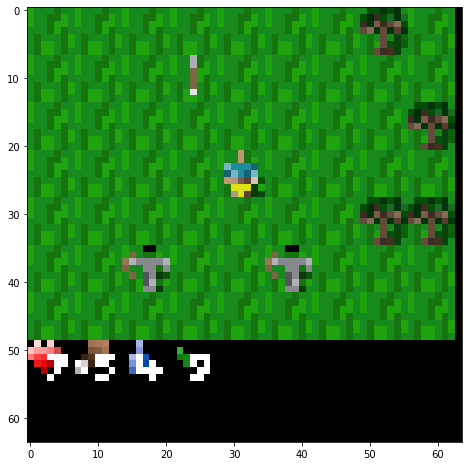

In [125]:
# recon_target = shapes[11]
# 10000, 50000, 12000, 17000, 18000
recon_target = dataset[13011]
plt.imshow(recon_target)

In [126]:
image = torch.from_numpy(to_batch_shape(recon_target).transpose(0, 3, 1, 2)).cuda() / 255
image.shape

torch.Size([1, 3, 64, 64])

In [127]:
model.eval()
outputs, latents = model(image)
op = outputs.detach().cpu().numpy().transpose(0, 2, 3, 1)

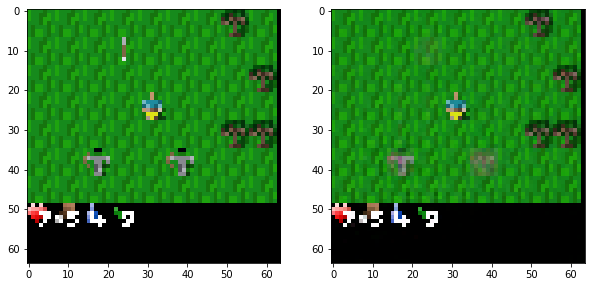

In [128]:
plt.subplot(1, 2, 1)
plt.imshow(recon_target)
plt.subplot(1, 2, 2)

plt.imshow(op[0])

In [129]:
outputs.shape, op.shape

(torch.Size([1, 3, 64, 64]), (1, 64, 64, 3))

In [130]:
to_batch_shape(recon_target).shape

(1, 64, 64, 3)

In [131]:
image = torch.from_numpy(to_batch_shape(recon_target)).permute((0, 3, 1, 2)).cuda() / 255
image.shape

torch.Size([1, 3, 64, 64])

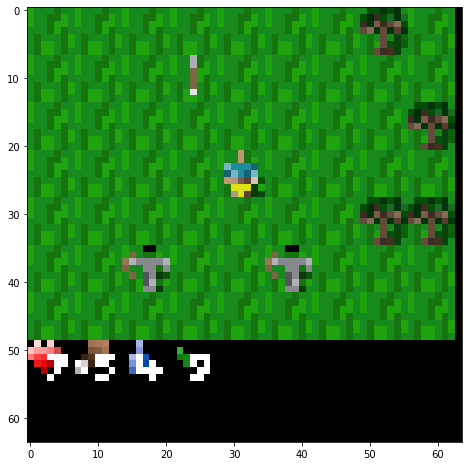

In [132]:
plt.imshow(image.cpu().numpy().transpose(0, 2, 3, 1)[0])

In [133]:
from delve import CheckLayerSat
tracker = CheckLayerSat("my_experiment", save_to="plotcsv", modules=model, device=image.device)

added layer encoder-0
Skipping encoder-1
Skipping encoder-2
added layer encoder-3
Skipping encoder-4
Skipping encoder-5
added layer encoder-6
Skipping encoder-7
Skipping encoder-8
added layer encoder-9
Skipping encoder-10
Skipping encoder-11
added layer latent-mu
added layer unlatent
Skipping decoder-0
Skipping decoder-1
Skipping decoder-2
Skipping decoder-3
Skipping decoder-4
Skipping decoder-5
Skipping decoder-6
Skipping decoder-7
Skipping decoder-8
Skipping decoder-9
Skipping decoder-10
Skipping decoder-11


my_experiment_lsat_eval_epoch_0.png


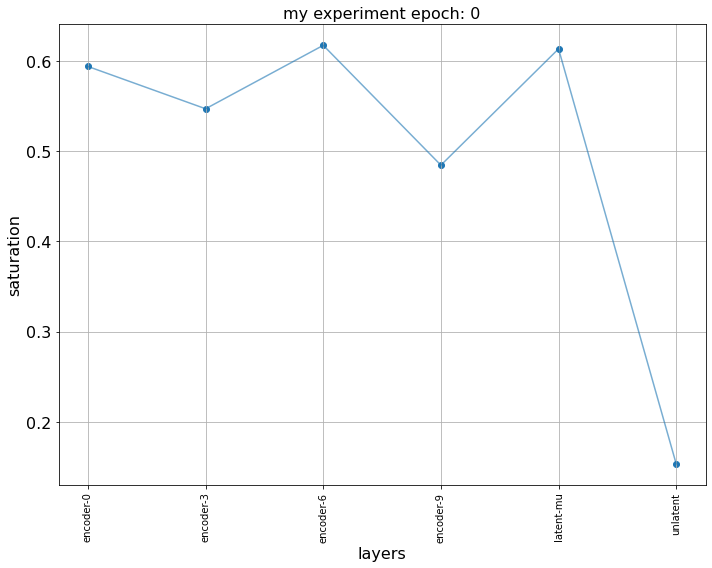

In [134]:
data = next(iter(train_dataloader))
image = data.permute((0, 3, 1, 2)).cuda() / 255
outputs, latents = model(image)
tracker.add_saturations()